In [1]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


(18795, 50)
None
(642,)


(array([ 26.,  92., 150., 141., 113.,  66.,  25.,  18.,   7.,   4.]),
 array([ 2.09478169,  3.6133982 ,  5.13201471,  6.65063122,  8.16924773,
         9.68786424, 11.20648075, 12.72509726, 14.24371378, 15.76233029,
        17.2809468 ]),
 <a list of 10 Patch objects>)

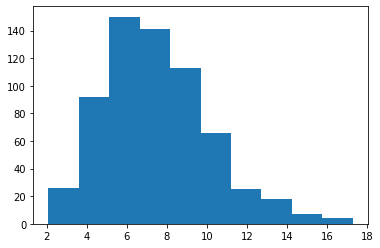

In [3]:
U=np.load('U.npy')
print(print(U.shape))
stim_ens_inds=np.nonzero(U[:,13])[0]
print(stim_ens_inds.shape)
stim_k=7.5
stim_theta=1.0
stim_weights=np.random.gamma(shape=stim_k,scale=stim_theta,size=(stim_ens_inds.shape[0],))
plt.hist(stim_weights)

(463,)


(array([245., 119.,  47.,  23.,  16.,   4.,   4.,   2.,   2.,   1.]),
 array([4.25335464e-03, 1.43313608e+00, 2.86201880e+00, 4.29090152e+00,
        5.71978424e+00, 7.14866697e+00, 8.57754969e+00, 1.00064324e+01,
        1.14353151e+01, 1.28641979e+01, 1.42930806e+01]),
 <a list of 10 Patch objects>)

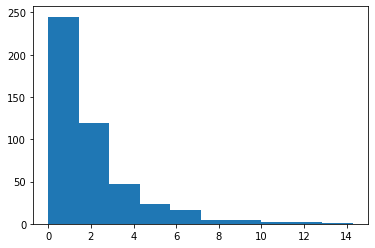

In [4]:
#Select beh ensemble, make weights for stim_ens
beh_ens_inds=np.nonzero(U[:,8])[0]
print(beh_ens_inds.shape)
beh_k=1.0
beh_theta=2.0
beh_weights=np.random.gamma(shape=beh_k,scale=beh_theta,size=(beh_ens_inds.shape[0],))
plt.hist(beh_weights)

In [5]:
weights=np.hstack((stim_weights,beh_weights))
print(weights.shape)

(1105,)


In [6]:
stim_inp=S[stim_ens_inds]
beh_imp=S[beh_ens_inds]
input_patterns=np.vstack((stim_inp,beh_imp))

In [7]:
del S
del spks

In [52]:
W=np.array([1.0])

def update_rates(x):
    #rates = x
    r_0 = 1.0
    r_max = 20.0
    x[x<=0] = r_0*np.tanh(x[x<=0]/r_0)
    x[x>0] = (r_max-r_0)*np.tanh(x[x>0]/(r_max-r_0))
    return x

def update_w(W,pre_syn_patterns,post_syn_patterns,theta_BCM):
    dt=0.001
    tau_w=0.01
    W+=dt*pre_syn_patterns*np.dot(post_syn_patterns,(post_syn_patterns-theta_BCM))/tau_w
    return W

def update_theta(theta_BCM,W,post_syn_patterns):
    dt=0.001
    BCM_target = 2.0
    tau_BCM=0.01
    theta_BCM+=dt*(-theta_BCM+post_syn_patterns*post_syn_patterns/BCM_target)/tau_BCM
    return theta_BCM

def one_timestep(W,pre_syn_patterns,post_syn_patterns,theta_BCM):
    dt=0.001
    W_max=1.0
    post_syn_patterns += dt*(-1*post_syn_patterns + np.dot(W,update_rates((pre_syn_patterns))))
    theta_BCM=update_theta(theta_BCM,W,post_syn_patterns)
    W=update_w(W,pre_syn_patterns,post_syn_patterns,theta_BCM)
    W = W*(0.5 * (np.sign(W) + 1))

    # bounding weights below max value
    W[W>W_max] = W_max
    #print(post_syn_patterns)
    #print(theta_BCM)
    print(post_syn_patterns)
    return post_syn_patterns,W,theta_BCM

def run_sim(pre_syn_patterns):
    W=np.array([1.0,2.0])
    post_syn_patterns=np.array([1.0])
    T=10000
    theta_BCM=np.array([1.0])
    
    Ws=[]
    
    xs=[]
    for i in range(T):
        post_syn_patterns, W, theta_BCM=one_timestep(W,pre_syn_patterns[:,i],post_syn_patterns,theta_BCM)
        Ws.append(W)
        xs.append(post_syn_patterns[-1])
    return xs, Ws

In [53]:
xs,Ws=run_sim(input_patterns[:2,:])
print(input_patterns)
print(xs)

[1.01460097]
[1.02708932]
[1.03959973]
[1.05199009]
[1.05770686]
[1.0634179]
[1.06912324]
[1.07482287]
[1.0805168]
[1.07943628]
[1.07835684]
[1.08470153]
[1.08361682]
[1.0897038]
[1.09605109]
[1.09495504]
[1.09386008]
[1.09276622]
[1.09167346]
[1.09798224]
[1.09688426]
[1.09578738]
[1.09469159]
[1.0935969]
[1.0925033]
[1.0914108]
[1.09031939]
[1.09665112]
[1.09555446]
[1.1018959]
[1.108231]
[1.11361141]
[1.1124978]
[1.11880479]
[1.1234905]
[1.129804]
[1.14353593]
[1.1423924]
[1.14125]
[1.14697588]
[1.14582891]
[1.14468308]
[1.14353839]
[1.14983185]
[1.15611636]
[1.16234801]
[1.16118566]
[1.16745861]
[1.16629115]
[1.16512486]
[1.17138281]
[1.17021143]
[1.16904122]
[1.16787217]
[1.1667043]
[1.1655376]
[1.16437206]
[1.16320769]
[1.16204448]
[1.16088244]
[1.15972155]
[1.15856183]
[1.15740327]
[1.15624587]
[1.15508962]
[1.15393453]
[1.1527806]
[1.15162782]
[1.15047619]
[1.14932571]
[1.14817639]
[1.14702821]
[1.14588118]
[1.1447353]
[1.14359057]
[1.14244698]
[1.14874152]
[1.14759278]
[1.1464

[2.01569808]
[2.01368238]
[2.0116687]
[2.00965703]
[2.00764737]
[2.00563972]
[2.00363408]
[2.00500197]
[2.00299697]
[2.00099397]
[1.99899298]
[1.99699398]
[1.99499699]
[1.99300199]
[1.99100899]
[1.98901798]
[1.98996582]
[1.98797585]
[1.98615209]
[1.98416594]
[1.9840004]
[1.9820164]
[1.98003439]
[1.97805435]
[1.97685197]
[1.97699021]
[1.97849566]
[1.97978678]
[1.97780699]
[1.97582919]
[1.97385336]
[1.97558005]
[1.98102455]
[1.97904353]
[1.97706449]
[1.97508742]
[1.97311233]
[1.97113922]
[1.96916808]
[1.96719892]
[1.96667455]
[1.96470787]
[1.96721575]
[1.96524854]
[1.96328329]
[1.96132]
[1.95935868]
[1.96134513]
[1.95938378]
[1.9574244]
[1.95931365]
[1.95735434]
[1.96003103]
[1.96306412]
[1.97053555]
[1.96856501]
[1.96753064]
[1.9655631]
[1.96359754]
[1.96163394]
[1.95967231]
[1.95771264]
[1.95575492]
[1.95379917]
[1.95184537]
[1.94989353]
[1.94794363]
[1.94599569]
[1.94902859]
[1.94707956]
[1.94513248]
[1.94318735]
[1.94124416]
[1.93930291]
[1.93736361]
[1.93542625]
[1.93349082]
[1.9315

[1.88627267]
[1.88615772]
[1.88427156]
[1.88951399]
[1.88762448]
[1.89193011]
[1.89003818]
[1.88814814]
[1.89353492]
[1.89800614]
[1.89610813]
[1.89421202]
[1.89231781]
[1.89676577]
[1.894869]
[1.90041113]
[1.90588979]
[1.9039839]
[1.91632999]
[1.91441366]
[1.91249924]
[1.91058674]
[1.90867616]
[1.90676748]
[1.90486071]
[1.90295585]
[1.9010529]
[1.89915184]
[1.90408824]
[1.90218415]
[1.90770107]
[1.90579337]
[1.90990925]
[1.90799935]
[1.90609135]
[1.90418525]
[1.91697633]
[1.92249635]
[1.92057385]
[1.92604675]
[1.9241207]
[1.92219658]
[1.92027438]
[1.91835411]
[1.91643576]
[1.91451932]
[1.9126048]
[1.9106922]
[1.9087815]
[1.90687272]
[1.90496585]
[1.90306088]
[1.90115782]
[1.89925666]
[1.89735741]
[1.89546005]
[1.89356459]
[1.89384893]
[1.89195508]
[1.89750004]
[1.90303954]
[1.90857349]
[1.90666492]
[1.90475825]
[1.90543273]
[1.9035273]
[1.90162377]
[1.89972215]
[1.90499563]
[1.90309063]
[1.90118754]
[1.89928636]
[1.89738707]
[1.89548968]
[1.89359419]
[1.89913759]
[1.89723845]
[1.89534

[1.93883751]
[1.93689867]
[1.94238632]
[1.94788093]
[1.95335744]
[1.96627807]
[1.97896341]
[1.98442144]
[1.99730002]
[2.00273969]
[2.00073695]
[1.99873621]
[1.99673747]
[1.99474073]
[1.99274599]
[1.99075325]
[1.9887625]
[1.99421072]
[1.99221651]
[1.9902243]
[1.98823407]
[1.98624584]
[1.98425959]
[1.98227533]
[1.98029306]
[1.97831276]
[1.97633445]
[1.97435812]
[1.97238376]
[1.97041138]
[1.96844096]
[1.96647252]
[1.96450605]
[1.96254154]
[1.9673398]
[1.96537246]
[1.96340709]
[1.96144368]
[1.97428504]
[1.97974775]
[1.977768]
[1.97579023]
[1.97381444]
[1.97184062]
[1.96986878]
[1.96789892]
[1.96937344]
[1.96740407]
[1.96543666]
[1.97090822]
[1.9763743]
[1.97439793]
[1.97242353]
[1.97788292]
[1.97590504]
[1.97392913]
[1.9719552]
[1.96998325]
[1.96801326]
[1.96604525]
[1.96407921]
[1.96211513]
[1.96015301]
[1.95819286]
[1.95623467]
[1.95427843]
[1.95232415]
[1.95037183]
[1.94842146]
[1.94647304]
[1.94452656]
[1.94258204]
[1.94063945]
[1.93869881]
[1.93676012]
[1.93482336]
[1.93288853]
[1.930

[1.95092309]
[1.94897216]
[1.94702319]
[1.94507617]
[1.94313109]
[1.94118796]
[1.93924677]
[1.94467288]
[1.94272821]
[1.94822247]
[1.95370961]
[1.95880926]
[1.95685045]
[1.9548936]
[1.9529387]
[1.95098576]
[1.94903478]
[1.94708574]
[1.94513866]
[1.94319352]
[1.94868732]
[1.95417251]
[1.95221834]
[1.95026612]
[1.94831586]
[1.95846946]
[1.96313858]
[1.96117544]
[1.95921427]
[1.95725506]
[1.9552978]
[1.95726006]
[1.9553028]
[1.9533475]
[1.95139415]
[1.94944276]
[1.95492204]
[1.95296711]
[1.95101415]
[1.94906313]
[1.95318579]
[1.9512326]
[1.94928137]
[1.94733209]
[1.94538475]
[1.94343937]
[1.94149593]
[1.94681469]
[1.94486788]
[1.94292301]
[1.94098009]
[1.93903911]
[1.93710007]
[1.93516297]
[1.9406648]
[1.94616113]
[1.94421496]
[1.94679149]
[1.9448447]
[1.94289985]
[1.94095695]
[1.939016]
[1.94451397]
[1.95000645]
[1.94805644]
[1.95354538]
[1.95159184]
[1.94964024]
[1.9476906]
[1.94574291]
[1.94379717]
[1.94185337]
[1.93991152]
[1.93797161]
[1.93603364]
[1.94139356]
[1.94664959]
[1.952014]

[1.91318461]
[1.91127143]
[1.91679715]
[1.91488035]
[1.92040247]
[1.92175749]
[1.91983573]
[1.9179159]
[1.92562277]
[1.92369715]
[1.93635457]
[1.9385443]
[1.94404274]
[1.94953569]
[1.95502315]
[1.96050512]
[1.95854461]
[1.96402306]
[1.96949603]
[1.96752653]
[1.98043299]
[1.99027327]
[1.98945984]
[2.00234436]
[2.01467116]
[2.02007215]
[2.01805208]
[2.02347016]
[2.03632067]
[2.04172135]
[2.04711662]
[2.05250649]
[2.05788891]
[2.05583103]
[2.06121219]
[2.05915098]
[2.06452882]
[2.06989987]
[2.07493271]
[2.08029477]
[2.08565023]
[2.08356458]
[2.08148101]
[2.08683652]
[2.09189581]
[2.08980392]
[2.08771411]
[2.0856264]
[2.09036595]
[2.09449458]
[2.09449769]
[2.09240319]
[2.09031079]
[2.08822048]
[2.08613226]
[2.09141673]
[2.08932532]
[2.09370012]
[2.09730193]
[2.09520463]
[2.09310943]
[2.09101632]
[2.0889253]
[2.08683638]
[2.08474954]
[2.08266479]
[2.08058213]
[2.08391093]
[2.09102699]
[2.08893596]
[2.08684703]
[2.08756493]
[2.08858487]
[2.08649629]
[2.08440979]
[2.08232538]
[2.08024305]
[2.

[2.00629146]
[2.0106624]
[2.00865174]
[2.00664309]
[2.00975246]
[2.00774271]
[2.00573497]
[2.00372923]
[2.00800645]
[2.00599845]
[2.00399245]
[2.00198846]
[1.99998647]
[2.00212534]
[2.0050986]
[2.00843916]
[2.00643073]
[2.00442429]
[2.00241987]
[2.00041745]
[1.99841703]
[1.99641862]
[1.9944222]
[1.99242778]
[1.99623287]
[1.99423663]
[1.9922424]
[1.99025015]
[1.9882599]
[1.99111443]
[1.98912332]
[1.99130187]
[1.99149885]
[1.98950735]
[1.98751784]
[1.98553033]
[1.9835448]
[1.98156125]
[1.97957969]
[1.98332119]
[1.98133787]
[1.97935653]
[1.98226229]
[1.98028002]
[1.98908805]
[1.99279044]
[1.99079765]
[1.98880685]
[1.9930858]
[1.99109272]
[1.98910163]
[1.98711252]
[1.98512541]
[1.98314029]
[1.98115715]
[1.97917599]
[1.97719681]
[1.98195306]
[1.97997111]
[1.97799113]
[1.97601314]
[1.97403713]
[1.97611751]
[1.9771247]
[1.97514757]
[1.97317242]
[1.97119925]
[1.96922805]
[1.96725882]
[1.96529157]
[1.97004414]
[1.9680741]
[1.97326328]
[1.97129001]
[1.96931872]
[1.9673494]
[1.96538205]
[1.963416

[1.83345589]
[1.83890614]
[1.83706723]
[1.83523016]
[1.83339493]
[1.83156154]
[1.82972998]
[1.82790025]
[1.83527588]
[1.83975509]
[1.83791533]
[1.84286515]
[1.84102228]
[1.83918126]
[1.83734208]
[1.83550474]
[1.83366923]
[1.83183556]
[1.83000373]
[1.82817372]
[1.82634555]
[1.8245192]
[1.82269468]
[1.82830898]
[1.83391738]
[1.83208346]
[1.83025138]
[1.82842113]
[1.82659271]
[1.82476612]
[1.82294135]
[1.82111841]
[1.81929729]
[1.81747799]
[1.81566052]
[1.81384485]
[1.81883805]
[1.81701921]
[1.82080278]
[1.81898198]
[1.82459999]
[1.82277539]
[1.82095261]
[1.8265617]
[1.82473514]
[1.82967266]
[1.82784299]
[1.82601515]
[1.83093591]
[1.82910497]
[1.83398758]
[1.83913335]
[1.83729421]
[1.83545692]
[1.84102432]
[1.8391833]
[1.83734411]
[1.83550677]
[1.83367126]
[1.8392493]
[1.84848264]
[1.85404131]
[1.86704783]
[1.86518078]
[1.8633156]
[1.86145228]
[1.85959083]
[1.85773124]
[1.85587351]
[1.85699018]
[1.85513319]
[1.86057647]
[1.86075081]
[1.85889006]
[1.86301054]
[1.86114753]
[1.87410042]
[1.8

[1.92055935]
[1.91863879]
[1.91672015]
[1.91480343]
[1.91288862]
[1.91097574]
[1.90906476]
[1.9071557]
[1.90524854]
[1.90958946]
[1.90849825]
[1.9102647]
[1.90835444]
[1.91388308]
[1.919406]
[1.9174866]
[1.91556911]
[1.91365354]
[1.91173989]
[1.90982815]
[1.90791832]
[1.9060104]
[1.90410439]
[1.90220028]
[1.90619222]
[1.90860677]
[1.90669817]
[1.90479147]
[1.91032367]
[1.91224575]
[1.91772794]
[1.919589]
[1.91766941]
[1.91575174]
[1.91383599]
[1.91192215]
[1.91001023]
[1.90810022]
[1.90619212]
[1.90428592]
[1.90238164]
[1.90047926]
[1.89857878]
[1.8966802]
[1.89478352]
[1.89452995]
[1.89263542]
[1.89074278]
[1.88885204]
[1.89600488]
[1.90826896]
[1.90636069]
[1.91178292]
[1.91645414]
[1.91453768]
[1.91813365]
[1.91621551]
[1.9142993]
[1.91751296]
[1.91559545]
[1.91367985]
[1.91920247]
[1.91728326]
[1.91536598]
[1.91355083]
[1.92257326]
[1.93534653]
[1.93341118]
[1.94616563]
[1.95165646]
[1.9497048]
[1.9477551]
[1.94580734]
[1.94386154]
[1.94935467]
[1.94740531]
[1.9528949]
[1.95094201]

[1.99132246]
[1.99676813]
[1.99477136]
[1.99551483]
[1.99351932]
[1.9915258]
[1.98953427]
[2.00092322]
[1.99892229]
[1.99692337]
[1.99492645]
[1.99293152]
[1.99093859]
[1.98894765]
[1.9869587]
[1.98497175]
[1.98298677]
[1.98100379]
[1.97902278]
[1.97704376]
[1.97506672]
[1.97309165]
[1.97847831]
[1.97649983]
[1.97452333]
[1.97254881]
[1.97632978]
[1.98117282]
[1.97919165]
[1.97721246]
[1.97523525]
[1.97326001]
[1.97128675]
[1.96931547]
[1.96734615]
[1.97277488]
[1.97812028]
[1.97614216]
[1.97416602]
[1.97219185]
[1.97760156]
[1.97562396]
[1.97364833]
[1.97167469]
[1.96970301]
[1.96773331]
[1.9683423]
[1.96637396]
[1.96440759]
[1.96244318]
[1.9680125]
[1.96604449]
[1.97096195]
[1.96899099]
[1.967022]
[1.96505498]
[1.96308992]
[1.96112684]
[1.96533719]
[1.96337186]
[1.96140848]
[1.95944708]
[1.95748763]
[1.96256096]
[1.96671674]
[1.97217147]
[1.9701993]
[1.9682291]
[1.96626087]
[1.96429461]
[1.96233032]
[1.96036798]
[1.95840762]
[1.9633157]
[1.96135238]
[1.95939103]
[1.95743164]
[1.95547

[2.00213951]
[2.00757437]
[2.00556679]
[2.00356123]
[2.00155766]
[1.99955611]
[1.99755655]
[1.99555899]
[1.99356343]
[1.99156987]
[1.9895783]
[1.98758872]
[1.99204319]
[1.99005115]
[1.99533998]
[2.00024746]
[2.00482918]
[2.00506702]
[2.01049777]
[2.00848727]
[2.00647878]
[2.0044723]
[2.00397486]
[2.00940788]
[2.01483546]
[2.02769453]
[2.03033722]
[2.02830688]
[2.02627857]
[2.0242523]
[2.02222804]
[2.02020582]
[2.01818561]
[2.01616742]
[2.01415126]
[2.01213711]
[2.01012497]
[2.00811484]
[2.00610673]
[2.00410062]
[2.00209652]
[2.00009442]
[1.99809433]
[1.99609624]
[2.00110385]
[1.99910275]
[1.99710365]
[1.99510654]
[1.99311144]
[1.99111833]
[1.98912721]
[1.98713808]
[1.99126964]
[1.98927837]
[1.99438222]
[1.99238783]
[1.99039545]
[1.99626796]
[1.9942717]
[1.99455131]
[1.99255676]
[1.9905642]
[1.98857364]
[1.99393885]
[1.99194491]
[1.98995297]
[1.99797484]
[2.00067755]
[2.0057586]
[2.00375284]
[2.00174909]
[1.99974734]
[2.00511761]
[2.01040288]
[2.00839247]
[2.01795249]
[2.01593454]
[2.01

[2.01373847]
[2.01172474]
[2.01681486]
[2.01479805]
[2.01278325]
[2.01077047]
[2.0087597]
[2.00675094]
[2.00474419]
[2.00273944]
[2.00546069]
[2.00345523]
[2.00145178]
[1.99945033]
[1.99745087]
[1.99545342]
[2.00089496]
[2.00696416]
[2.00495719]
[2.00295223]
[2.00094928]
[1.99894833]
[1.99694939]
[1.99495244]
[1.99295748]
[1.99096453]
[1.98897356]
[1.98698459]
[1.9849976]
[1.99041685]
[1.99582413]
[1.99382831]
[1.99927147]
[2.00411434]
[2.00954722]
[2.01469672]
[2.01998041]
[2.01796043]
[2.01594247]
[2.01392653]
[2.0119126]
[2.00990069]
[2.00789079]
[2.0058829]
[2.00387701]
[2.00187314]
[1.99987126]
[1.99787139]
[1.99587352]
[1.99387765]
[1.99188377]
[1.98989189]
[1.98790199]
[1.98591409]
[1.98778764]
[1.99202631]
[1.99003429]
[1.99017004]
[1.98817987]
[1.98619169]
[1.9842055]
[1.98222129]
[1.98023907]
[1.97825883]
[1.9836616]
[1.98167794]
[1.97969626]
[1.97771657]
[1.97573885]
[1.97376311]
[1.97178935]
[1.96981756]
[1.97512623]
[1.9805881]
[1.97860751]
[1.9766289]
[1.97465227]
[1.9801

In [8]:
print(input_patterns.shape)

(1105, 30560)
